<a href="https://colab.research.google.com/github/WeiHao-19/deep-learning-with-python-notebooks/blob/master/classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.4.3'

**路透社数据集**它包括46个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少10 个样本。

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


与IMDB数据集一样，参数 num_words=10000 将数据限定为前 10000 个最常出现的单词。
我们有 8982 个训练样本和 2246 个测试样本。

In [4]:
len(train_data)


8982


In [5]:
len(test_data)

2246

In [7]:
train_data[22]

[1,
 2,
 71,
 8,
 16,
 385,
 6,
 42,
 904,
 103,
 727,
 27,
 682,
 7879,
 451,
 18,
 79,
 5,
 49,
 175,
 80,
 9,
 1379,
 6,
 406,
 42,
 549,
 451,
 18,
 79,
 2,
 8,
 4,
 587,
 848,
 4,
 1651,
 310,
 22,
 134,
 72,
 20,
 6,
 196,
 44,
 20,
 4,
 39,
 1154,
 6,
 4,
 49,
 135,
 32,
 63,
 11,
 15,
 4,
 49,
 8,
 4,
 1379,
 55,
 2,
 117,
 4,
 225,
 109,
 206,
 28,
 258,
 132,
 15,
 90,
 67,
 5,
 175,
 80,
 519,
 6,
 2,
 17,
 12]

拉片train_data中sequence中的第23个

In [10]:
# word_index 是一个将单词映射为整数索引的字典
word_index = reuters.get_word_index()
# 通过reverse，键值颠倒，把整数索引映射为单词
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note我们的索引indics减去了‘3’
# 因为 0, 1  2 是为 填充"padding", 序列开始"start of sequence", 和未知词"unknown"分别保留的索引.
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [11]:
# 将其中一条newswire解码处理看看，可以看出‘？？？’说明全部的newswires已经成功解码
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [14]:
# 注意labels永远是一组标量
train_labels[22]

4

In [15]:
# 准备数据
# 此处就是编码数据，使其向量化
import numpy as np

# 定义（创建）一个矩阵，这个矩阵以sequences为长，以10000维度为宽
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
# 进入for循环，对于enumerate列举出的i条sequences，将results[i]的指定索引设为1
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 我们的训练数据vectorized
x_train = vectorize_sequences(train_data)
# 我们的测试数据vectorized
x_test = vectorize_sequences(test_data)

In [16]:
# 将标签向量化有两种方法：
# 1.将标签列表转换为整数张量，
# 2.使用 one-hot 编码。
# one-hot 编码是分类数据广泛使用的一种格式，也叫分类编码（categorical encoding）。在这个例子中，标签的 one-hot 编码就是将每个标签表示为*全零向量*，
# 只有标签索引对应的元素为 1。其代码实现如下：
# 从keras的np函数集合中导入
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [17]:
# 这一步构建网络
# 考虑到这个主题分类问题是对简短的文本片段进行分类，但这个问题有一个新的约束条件：输出类别的数量从 2 个（二分类）变为 46 个（多分类）。
# 输出空间的维度要大得多。
# 故而不能简单的使用 Dense 层的堆叠，（因为每层只能访问上一层输出的信息）。
# 如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。（猜测隐含层数量要求极高）
# 因此，此例中，我们不再简单使用 16 维的中间层，对这个例子来说 16 维空间可能太小了，无法学会区分 46 个不同的类别。这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。
# 出于这个原因，下面将使用维度更大的层，包含 64 个单元。（这种解决思路无论在算力解放与否的情况下，大规模使用都只能算是一种为保守地维持鲁棒性而几何级压榨算力）
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

### 关于这个架构还应该注意另外两点。
- 网络的最后一层是大小为 46 的 Dense 层。这意味着，对于每个输入样本，网络都会输
出一个 46 维向量。这个向量的每个元素（即每个维度）代表不同的输出类别。
- 最后一层使用了 softmax 激活。这种用法是指网络将输出在 46 个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个 46 维向量（对接上文一点），其中 output[i] 是样本属于第 i 个类别的概率。46 个概率的总和为 1。对于这个例子，最好的损失函数是 categorical_crossentropy（分类交叉熵）。它用于衡量两个概率分布之间距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。

In [18]:
# 编译模型
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# 这一步再在训练集中切出1000个来作为验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [21]:
# 开始training，共计20个epochs
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 64ms/step - loss: 3.0915 - accuracy: 0.4398 - val_loss: 1.7155 - val_accuracy: 0.6480
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 1.4862 - accuracy: 0.6891 - val_loss: 1.3087 - val_accuracy: 0.7060
Epoch 3/20
16/16 [==============================] - 1s 48ms/step - loss: 1.1014 - accuracy: 0.7608 - val_loss: 1.1460 - val_accuracy: 0.7430
Epoch 4/20
16/16 [==============================] - 1s 48ms/step - loss: 0.8774 - accuracy: 0.8111 - val_loss: 1.0480 - val_accuracy: 0.7740
Epoch 5/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6970 - accuracy: 0.8538 - val_loss: 0.9723 - val_accuracy: 0.8000
Epoch 6/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5593 - accuracy: 0.8825 - val_loss: 0.9850 - val_accuracy: 0.7800
Epoch 7/20
16/16 [==============================] - 1s 48ms/step - loss: 0.4733 - accuracy: 0.9015 - val_loss: 0.9278 - val_accuracy: 0.8110
Epoch 8/20
16

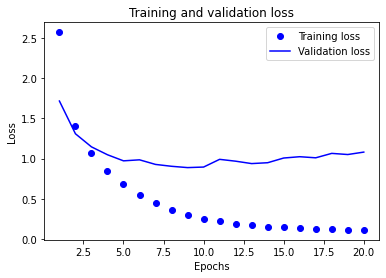

In [22]:
# 绘制损失曲线loss curves和精度曲线accuracy curves看看效果咯
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

这一步就能看出 20个epochs 可谓是处心积虑而恰到好处，既能得到较好的预期泛化，又能减轻算力负担

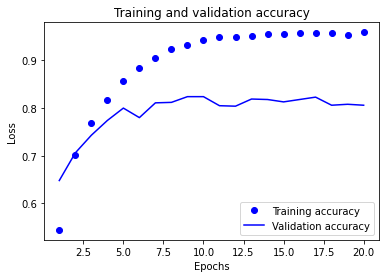

In [24]:
# 再来看看训练精度和验证精度
plt.clf()   # 清除上一步的训练损失和验证损失 figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
# 网络在epoch 8、9 轮后开始过拟合。我们从头开始训练一个新网络，共 8 个轮次，然后在测试集上评估模型。
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 1s 57ms/step - loss: 3.2580 - accuracy: 0.3682 - val_loss: 1.8544 - val_accuracy: 0.6430
Epoch 2/8
16/16 [==============================] - 1s 48ms/step - loss: 1.6550 - accuracy: 0.6848 - val_loss: 1.3245 - val_accuracy: 0.7060
Epoch 3/8
16/16 [==============================] - 1s 48ms/step - loss: 1.1383 - accuracy: 0.7669 - val_loss: 1.1272 - val_accuracy: 0.7560
Epoch 4/8
16/16 [==============================] - 1s 48ms/step - loss: 0.8592 - accuracy: 0.8212 - val_loss: 1.0448 - val_accuracy: 0.7730
Epoch 5/8
16/16 [==============================] - 1s 47ms/step - loss: 0.6758 - accuracy: 0.8640 - val_loss: 0.9823 - val_accuracy: 0.7960
Epoch 6/8
16/16 [==============================] - 1s 46ms/step - loss: 0.5461 - accuracy: 0.8901 - val_loss: 0.9354 - val_accuracy: 0.8010
Epoch 7/8
16/16 [==============================] - 1s 49ms/step - loss: 0.4257 - accuracy: 0.9107 - val_loss: 0.9000 - val_accuracy: 0.8190
Epoch 8/8
71/71 [===

In [26]:
# 看一下最终结果
results

[0.9694028496742249, 0.7845057845115662]

In [27]:
# 看一下完全随机的分类精度，比19%稍微高一点
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19412288512911843

In [29]:
# 这种方法可以得到约 80% 的精度。对于平衡的二分类问题，完全随机的分类器能够得到50%的精度。
# 但在这个例子中，完全随机的精度约为19%，我估计训练9轮可能精度也只会在19%上下，所以就不再演示9个epochs的结果了。
# 下面看一下在新数据上生成预测结果
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [30]:
# predictions 中的每个元素都是长度为 46 的向量，那么这个向量的所有元素总和呢
np.sum(predictions[0])

1.0

In [31]:
# 最大的元素就是预测类别，即概率最大的类别。
np.argmax(predictions[0])

3

In [32]:
# 回到处理标签和损失的另一种方法：将标签列表转换为整数张量
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

对于这种编码方法，唯一需要改变的是损失函数的选择。对于one-hot encoding使用的损失
函数 categorical_crossentropy，标签应该遵循分类编码。对于整数标签，你应该使用
sparse_categorical_crossentropy。
这个新的损失函数在数学上与 categorical_crossentropy 完全相同，二者只是接口不同。

In [35]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 3.6051 - accuracy: 0.0563 - val_loss: 2.8308 - val_accuracy: 0.2530
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 2.5815 - accuracy: 0.2782 - val_loss: 2.1223 - val_accuracy: 0.2870
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 1.8818 - accuracy: 0.3499 - val_loss: 1.6035 - val_accuracy: 0.6700
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 1.3748 - accuracy: 0.6944 - val_loss: 1.4336 - val_accuracy: 0.6740
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 1.1682 - accuracy: 0.7116 - val_loss: 1.3846 - val_accuracy: 0.6830
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 1.0718 - accuracy: 0.7244 - val_loss: 1.3395 - val_accuracy: 0.6970
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.9494 - accuracy: 0.7637 - val_loss: 1.3289 - val_accuracy: 0.7100
Epoch 8/20
63

### 中间层维度足够大的重要性
前面用过的最终输出是 46 维的，因此中间层的隐藏单元个数不应该比 46 小太多。现在来
试试，如果中间层的维度远远小于 46（比如 4 维），造成了信息瓶颈，那么会发生什么？
- 结果还是比较直观的71.7%，已经接近72%了，比之前中间层使用46维的（81.6%）少了10%！
- 分析一下原因，我认为下降这么多，将大量信息（这些信息足够恢复 46 个类别的分割超平面）压缩到维度很小的中间空间。网络能够将大部分必要信息塞入这个四维表示中，但并不可避免丢掉一些必要的信息，而这两部分信息的总和才是全部必要的信息。

In [36]:
# 继续实验，这次中间层的隐藏单元是‘32’，其他条件不变
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 2.4675 - accuracy: 0.5042 - val_loss: 1.2843 - val_accuracy: 0.7060
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 0.7142 - accuracy: 0.8520 - val_loss: 0.9198 - val_accuracy: 0.8000
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 0.5161 - accuracy: 0.8907 - val_loss: 0.8925 - val_accuracy: 0.8100
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 0.3678 - accuracy: 0.9258 - val_loss: 0.8617 - val_accuracy: 0.8230
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 0.2829 - accuracy: 0.9380 - val_loss: 0.8828 - val_accuracy: 0.8250
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.2280 - accuracy: 0.9454 - val_loss: 0.9174 - val_accuracy: 0.8230
Epoch 8/20
63/63 [==============================] - 1s 17ms/step - loss: 0.1750 - accuracy: 0.9550 - val_loss: 0.9799 - val_accuracy: 0.8110
Epoch 9/20
63

分类精度80.2%，对比下，下降还可以接受

In [37]:
# 最后实验一下，这次中间层的隐藏单元是‘128’，其他条件不变
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 2.3047 - accuracy: 0.5131 - val_loss: 1.1974 - val_accuracy: 0.7330
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 0.9819 - accuracy: 0.7884 - val_loss: 0.9902 - val_accuracy: 0.7780
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 0.6152 - accuracy: 0.8642 - val_loss: 0.9142 - val_accuracy: 0.8060
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 0.3963 - accuracy: 0.9168 - val_loss: 0.8696 - val_accuracy: 0.8250
Epoch 5/20
63/63 [==============================] - 1s 18ms/step - loss: 0.2733 - accuracy: 0.9368 - val_loss: 0.9255 - val_accuracy: 0.8170
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 0.2052 - accuracy: 0.9497 - val_loss: 0.9317 - val_accuracy: 0.8130
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 0.1706 - accuracy: 0.9572 - val_loss: 0.9549 - val_accuracy: 0.8050
Epoch 8/20
63

中间层的隐藏单元个数达到128之后，分类反而下降到和32层相当，我猜想极可能是因为隐藏层中的神经元（隐藏单元）过多而导致的过拟合(overfitting)。当神经网络具有过多的节点（过多的信息处理能力）时，训练集中包含的有限信息量（相比128层就太少了）不足以训练隐藏层中的所有神经元，因此就会导致过拟合。即使训练数据包含的信息量足够，隐藏层中过多的神经元会增加训练时间，从而难以达到预期的效果。就这样啦！